<a href="https://colab.research.google.com/github/budennovsk/test_metro_predict/blob/budennovsk/test_predict_model_coffee_shop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost

In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor

from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split, cross_val_score



In [ ]:
df = pd.read_excel('/content/dataset_renamed.xlsx')
df

,id,target,Расстояние до метро,"Суммарное кол-во отзывов в категории ""АЗС"" в радиусе 150м","Суммарное кол-во отзывов в категории ""Алкомаркеты"" в радиусе 150м","Суммарное кол-во отзывов в категории ""Аптеки"" в радиусе 150м","Суммарное кол-во отзывов в категории ""Банки"" в радиусе 150м","Суммарное кол-во отзывов в категории ""Бизнес_центры"" в радиусе 150м","Суммарное кол-во отзывов в категории ""ВУЗы"" в радиусе 150м","Суммарное кол-во отзывов в категории ""Вокзалы"" в радиусе 150м",...,Суммарный вечерний трафик сигналов рабочих в радиусе 140м,Суммарный трафик сигналов рабочих в радиусе 140м,Суммарный утренний трафик юзеров рабочих в радиусе 140м,Суммарный дневной трафик юзеров рабочих в радиусе 140м,Суммарный вечерний трафик юзеров рабочих в радиусе 140м,Суммарный трафик юзеров рабочих в радиусе 140м,Тип БЦ,Тип хаб,Тип улица,Тип ТЦ
0,60,1.292717,5526.692151,0,274,56,156,249,0,0,...,33,187,3,6,3,6,0,0,1,0
1,50,1.674569,16243.183872,0,0,719,402,0,0,0,...,303,1302,9,12,11,15,0,0,0,1
2,17,1.140666,6401.230357,0,194,425,271,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,15,1.352501,2255.498620,0,0,0,0,1737,83,0,...,52,315,6,7,5,10,0,0,1,0
4,74,1.324726,5811.209297,0,0,71,0,0,0,0,...,257,1189,2,2,2,2,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,112,NaN,19887.712950,0,0,193,32,0,0,0,...,185,1074,6,6,7,8,0,0,0,1
94,117,NaN,485.615204,0,1258,237,103,372,60,0,...,351,1529,9,10,10,13,0,0,1,0
95,126,NaN,2420.989438,0,146,346,16,20,0,0,...,129,437,8,10,6,14,0,0,1,0
96,144,NaN,11997.377318,0,85,414,547,0,0,0,...,91,309,10,10,9,12,0,0,1,0


In [ ]:
df = df.head(81)
df

,id,target,Расстояние до метро,"Суммарное кол-во отзывов в категории ""АЗС"" в радиусе 150м","Суммарное кол-во отзывов в категории ""Алкомаркеты"" в радиусе 150м","Суммарное кол-во отзывов в категории ""Аптеки"" в радиусе 150м","Суммарное кол-во отзывов в категории ""Банки"" в радиусе 150м","Суммарное кол-во отзывов в категории ""Бизнес_центры"" в радиусе 150м","Суммарное кол-во отзывов в категории ""ВУЗы"" в радиусе 150м","Суммарное кол-во отзывов в категории ""Вокзалы"" в радиусе 150м",...,Суммарный вечерний трафик сигналов рабочих в радиусе 140м,Суммарный трафик сигналов рабочих в радиусе 140м,Суммарный утренний трафик юзеров рабочих в радиусе 140м,Суммарный дневной трафик юзеров рабочих в радиусе 140м,Суммарный вечерний трафик юзеров рабочих в радиусе 140м,Суммарный трафик юзеров рабочих в радиусе 140м,Тип БЦ,Тип хаб,Тип улица,Тип ТЦ
0,60,1.292717,5526.692151,0,274,56,156,249,0,0,...,33,187,3,6,3,6,0,0,1,0
1,50,1.674569,16243.183872,0,0,719,402,0,0,0,...,303,1302,9,12,11,15,0,0,0,1
2,17,1.140666,6401.230357,0,194,425,271,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,15,1.352501,2255.498620,0,0,0,0,1737,83,0,...,52,315,6,7,5,10,0,0,1,0
4,74,1.324726,5811.209297,0,0,71,0,0,0,0,...,257,1189,2,2,2,2,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,9,1.129976,15800.434812,0,26,776,418,0,0,0,...,406,2118,12,13,11,15,0,0,0,1
77,18,1.202719,6720.167057,0,3,0,0,0,12,0,...,19,123,3,4,2,5,0,0,1,0
78,7,1.252003,5941.711807,0,25,18,0,0,0,0,...,98,1724,5,7,4,7,0,0,1,0
79,135,1.496835,13033.452864,0,0,214,22,0,0,0,...,614,1695,15,19,16,23,0,0,0,1


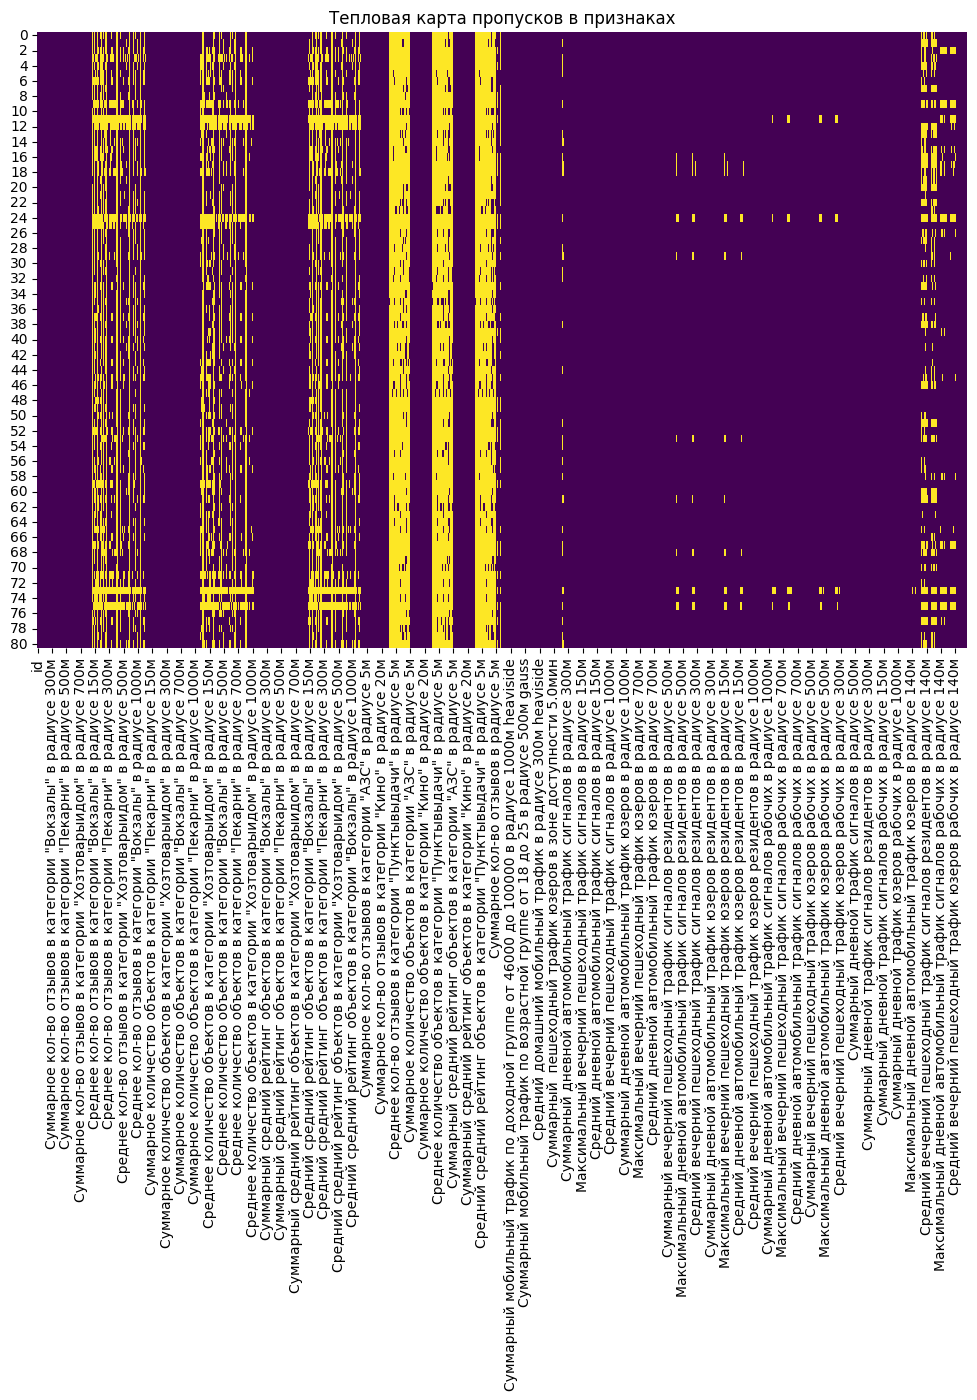

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Создание тепловой карты пропусков в признаках
plt.figure(figsize=(12, 8))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Тепловая карта пропусков в признаках')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool, cv
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

# Примерные данные (предположим, что df уже подготовлен)
# X - это признаки, а y - целевая переменная
X = df.drop(['target'], axis=1)  # Признаки
X = X.fillna(0).copy()

y = df['target']  # Целевая переменная

# Находим колонки, названия которых начинаются с "Среднее количество объектов в категории"
columns_to_find = [col for col in X.columns if col.startswith('Среднее количество объектов в категории')]

# Выводим найденные колонки
print(f"Найденные категориальные колонки: {columns_to_find}")

# Категориальные признаки (указываем индексы или названия категориальных признаков)
cat_features = ['id'] + columns_to_find  # Пример категориальных признаков
X[cat_features] = X[cat_features].astype(int)

# Разделим данные на тренировочные и тестовые (предположим, что первые 70% — это обучение, последние 30% — тест)
train_size = int(0.9 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Создаем Pool для тренировочных данных
train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)

# Параметры модели
params = {
    'iterations': 500,        # Количество итераций
    'depth': 4,               # Глубина деревьев
    'learning_rate': 0.1,     # Скорость обучения
    'loss_function': 'MAE',  # Основная метрика
    'verbose': 100            # Показывать процесс обучения каждые 100 итераций
}

# Выполнение кросс-валидации с 5 фолдами
cv_data = cv(
    params=params,         # Параметры модели
    pool=train_pool,       # Данные в формате Pool
    fold_count=2,          # Количество фолдов для кросс-валидации
    shuffle=True,          # Перемешивание данных перед каждой итерацией
    partition_random_seed=42,  # Для воспроизводимости
    verbose=False          # Отключение вывода результатов на экран
)

# Преобразуем результаты в DataFrame
cv_results = pd.DataFrame(cv_data)

# Вычисление средних значений по метрикам
mean_rmse = cv_results['test-MAE-mean'].values[-1]  # Средний RMSE

# Обучаем модель на всех тренировочных данных
model = CatBoostRegressor(**params)
model.fit(train_pool, verbose=False)

# Создаем Pool для тестовых данных
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

# Делаем предсказания на тестовом наборе
y_pred = model.predict(test_pool)

# Вычисляем метрики на тестовом наборе
rmse = mean_squared_error(y_test, y_pred, squared=False)  # RMSE
# Вычисляем обычный R²
r2 = r2_score(y_test, y_pred)

# Количество наблюдений
n = len(y_test)

# Количество признаков (p)
p = X_test.shape[1]

# Вычисляем скорректированный R²
r2_adj = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Выводим результат

mape = mean_absolute_percentage_error(y_test, y_pred) * 100  # MAPE
wape = np.sum(np.abs(y_test - y_pred)) / np.sum(np.abs(y_test)) * 100  # WAPE

# Выводим результаты метрик
print(f"Среднее значение RMSE на кросс-валидации: {mean_rmse}")
print(f"RMSE на тестовых данных: {rmse}")
print(f"Скорректированный R²: {r2_adj}")
print(f"MAPE на тестовых данных: {mape}")
print(f"WAPE на тестовых данных: {wape}")


Найденные категориальные колонки: ['Среднее количество объектов в категории "АЗС" в радиусе 150м', 'Среднее количество объектов в категории "Алкомаркеты" в радиусе 150м', 'Среднее количество объектов в категории "Аптеки" в радиусе 150м', 'Среднее количество объектов в категории "Банки" в радиусе 150м', 'Среднее количество объектов в категории "Бизнес_центры" в радиусе 150м', 'Среднее количество объектов в категории "ВУЗы" в радиусе 150м', 'Среднее количество объектов в категории "Вокзалы" в радиусе 150м', 'Среднее количество объектов в категории "Детскиемагазины" в радиусе 150м', 'Среднее количество объектов в категории "Жилыедома" в радиусе 150м', 'Среднее количество объектов в категории "Кино" в радиусе 150м', 'Среднее количество объектов в категории "Косметика" в радиусе 150м', 'Среднее количество объектов в категории "Кофейня" в радиусе 150м', 'Среднее количество объектов в категории "Метро_МЦК_ж/д" в радиусе 150м', 'Среднее количество объектов в категории "Общепит" в радиусе 150м'

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


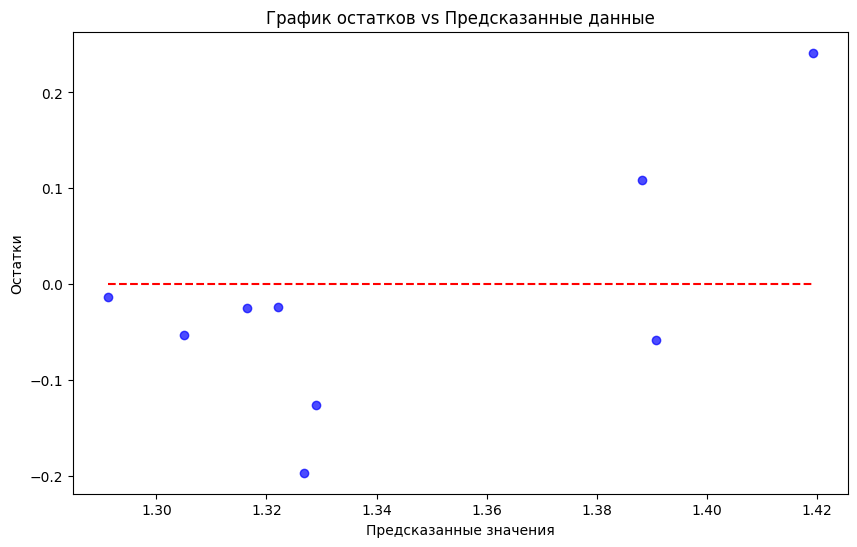

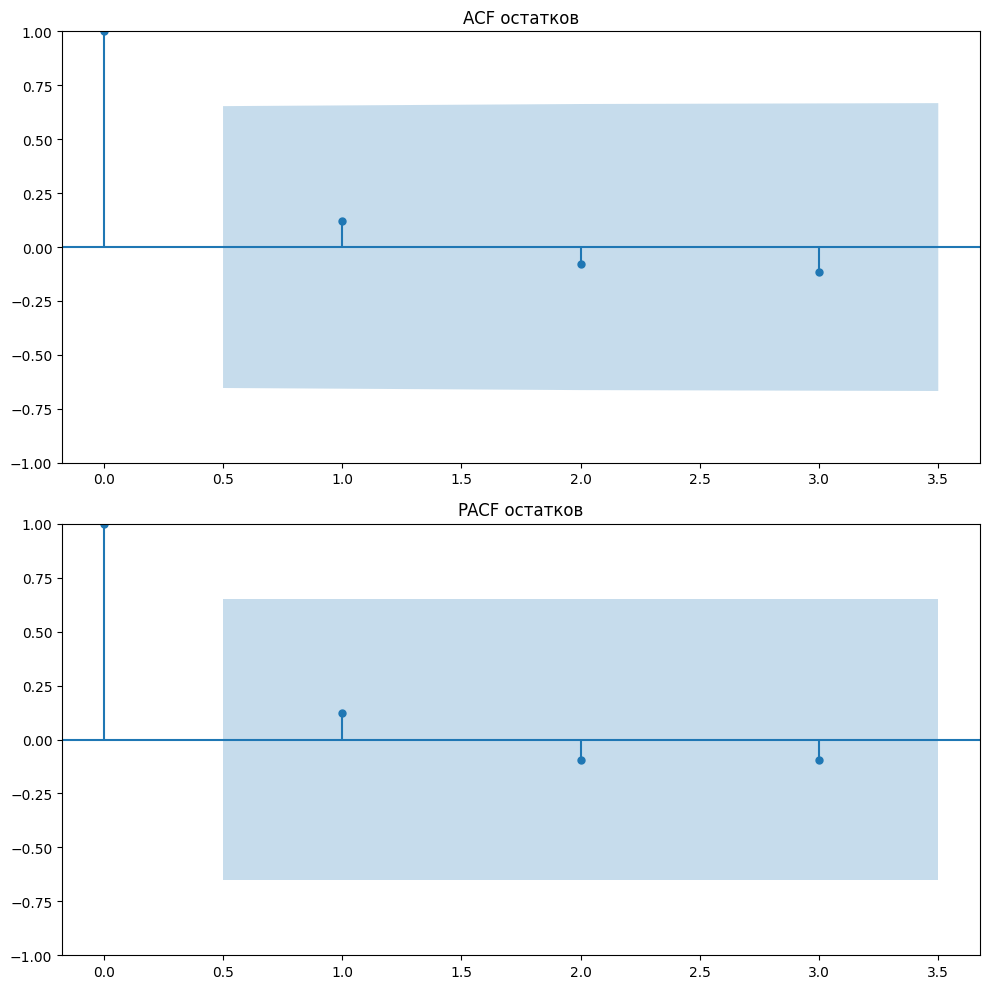

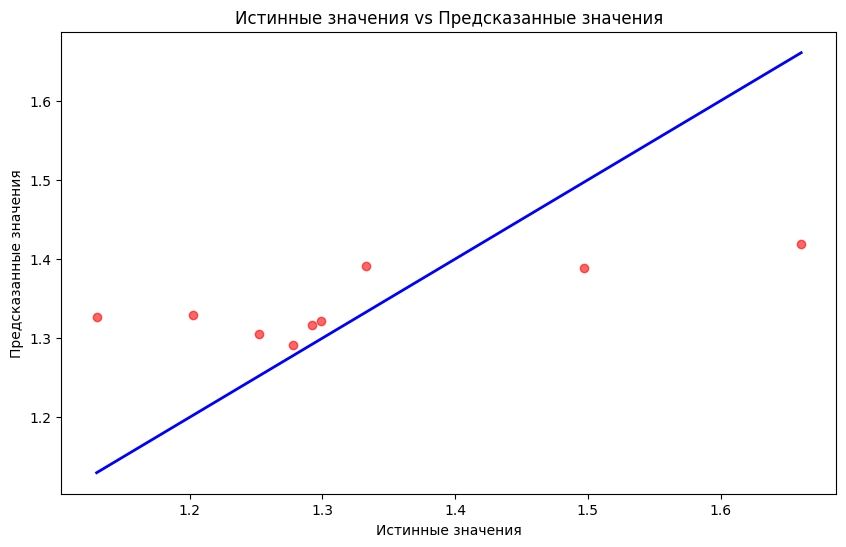

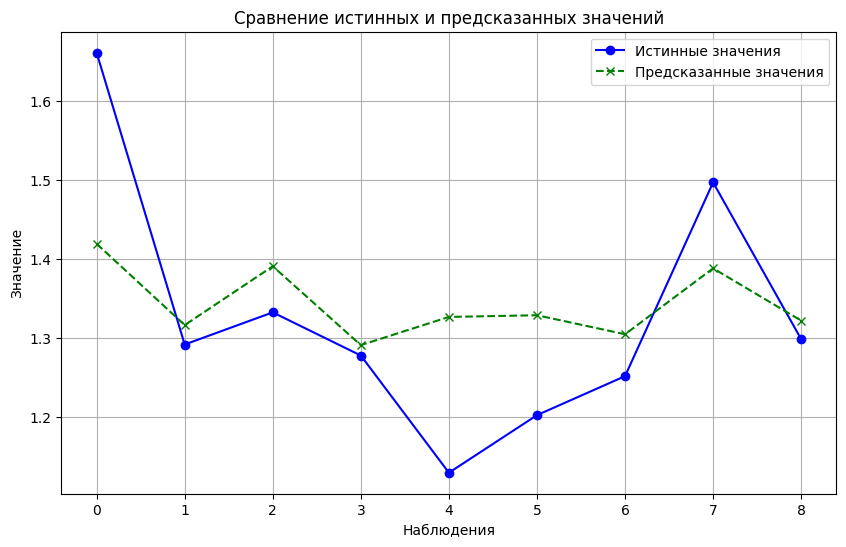

   lb_stat  lb_pvalue
3   0.4955   0.919879
P-value = 0.91988. Остатки не являются статистически значимыми и ведут себя как белый шум.
RMSE на тестовых данных: 0.1212600003932275
Скорректированный R²: 1.0022250200681255
MAPE на тестовых данных: 7.00581297275986
WAPE на тестовых данных: 7.079647897460693


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Вычисляем остатки (разница между фактическими и предсказанными значениями)
residuals = y_test - y_pred

# Построение графика остатков
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.7, color="b")
plt.hlines(0, min(y_pred), max(y_pred), colors='r', linestyles='dashed')
plt.title('График остатков vs Предсказанные данные')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.show()

# Построим графики ACF и PACF для остатков
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
plot_acf(residuals, ax=ax[0], lags=3)
ax[0].set_title('ACF остатков')
plot_pacf(residuals, ax=ax[1], lags=3)
ax[1].set_title('PACF остатков')
plt.tight_layout()
plt.show()

# Построим точечный график истинных значений и предсказанных
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='red', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='blue', lw=2)
plt.title('Истинные значения vs Предсказанные значения')
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.show()

import matplotlib.pyplot as plt

# Построим график истинных значений и предсказанных для Leave-One-Out
plt.figure(figsize=(10, 6))

# Линия истинных значений
plt.plot(y_test.values, label='Истинные значения', color='blue', marker='o', linestyle='-')

# Линия предсказанных значений
plt.plot(y_pred, label='Предсказанные значения', color='green', marker='x', linestyle='--')

# Настройки графика
plt.title('Сравнение истинных и предсказанных значений')
plt.xlabel('Наблюдения')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)
plt.show()


# Выводим метрики для тестового набора
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

# Количество наблюдений
n = len(y_test)

# Количество признаков (p)
p = X_test.shape[1]

# Вычисляем скорректированный R²
r2_adj = 1 - (1 - r2) * (n - 1) / (n - p - 1)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
wape = np.sum(np.abs(y_test - y_pred)) / np.sum(np.abs(y_test)) * 100


from statsmodels.stats.diagnostic import acorr_ljungbox
# Тест Ljung-Box на белый шум
ljung_box_result = acorr_ljungbox(residuals, lags=[3], return_df=True)

# Вывод результата теста Ljung-Box
print(ljung_box_result)
# Интерпретация результатов теста Ljung-Box
p_value = ljung_box_result['lb_pvalue'].iloc[0]

if p_value > 0.05:
    print(f"P-value = {p_value:.5f}. Остатки не являются статистически значимыми и ведут себя как белый шум.")
else:
    print(f"P-value = {p_value:.5f}. Остатки статистически значимы, и есть автокорреляция (не белый шум).")


print(f"RMSE на тестовых данных: {rmse}")
print(f"Скорректированный R²: {r2_adj}")
print(f"MAPE на тестовых данных: {mape}")
print(f"WAPE на тестовых данных: {wape}")